See original notebook : https://drive.google.com/drive/folders/1XMUXYtEcop8nSm6mFY6nxNCmOiJgswC8?usp=share_link

Install packages, may need to restart runtime at the end

In [11]:
!pip install lifelines
!pip install pgmpy==0.1.11
!pip install bnlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pgmpy-0.1.22-py3-none-any.whl (1.9 MB)
  Attempting uninstall: pgmpy
    Found existing installation: pgmpy 0.1.11
    Uninstalling pgmpy-0.1.11:
      Successfully uninstalled pgmpy-0.1.11


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
%cd "/content/drive/My Drive/Colab Notebooks/Projects_for_Github/Predictive maintenance/"

/content/drive/My Drive/Colab Notebooks/Projects_for_Github/Predictive maintenance


# Imports

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import random
import scipy.stats as ss

import h5py
import bnlearn
import missingno
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit
from lifelines import KaplanMeierFitter

# Predictive maintenance

The maintenance concerns a lot of industry sectors (heavy industries, transport, farming, building, real estate, health, IT). It gathers several stakes :

* Economic challenges : in terms of employment and expenses
* Security challenges : prevent accidents
* Environmental challenges : prevent the waste of equipments which still work
* Mixed challenges on the adaptation of needs of the industry, amelioration of the terms of use of the equipments, or bringing a better image of the company 

The big challenges of maintenance are :

* The curative/corrective maintenance
* The preventive maintenance
* The predictive maintenance
* The meliorative maintenance

The maintenance type for optimising costs is the predictive maintenance, as it takes into account a optimisation strategy for costs

# Life distributions and maintenance strategy


We can look at

* Maximum likelihood with exponential distribution
* Maximum likelihood with Weibull distribution

for parametric estimations of life distributions and

* Non parametric Kaplan-Meier estimation for the survival function
* Non-parametric Nelson-Aalen estimation for modelling the cumulative default rate

for non parametric estimations.

A censored data is a data having a measurement value which is only partially known. For example, we do not know the time to failure of a certain piece in the system, but we can say it is working at the current instant t.

In [4]:
filename: str = "Dataset_2.1.csv"
data = pd.read_csv(filename, sep=',')
data.head()

,Unnamed: 0,usage,Temperature,Pression,censored,event (fail or censored)
0,0,False,14.975284,1000.695430,False,374.96963956347
1,1,False,16.857807,992.757881,False,336.45767926983166
2,2,False,18.565954,1002.509288,False,268.89438720990216
3,3,True,14.681768,994.701873,False,59.60865767745483
4,4,False,16.365552,995.131057,False,573.565608383586


We compute a parametric and a non-parametric method : a Weibull distribution and estimation of Kaplan-Meier. The Weibull distribution is often used for modelising life distributions.

estimation k: 1.0756203289115371 estimation lambda: 5405.37646218179


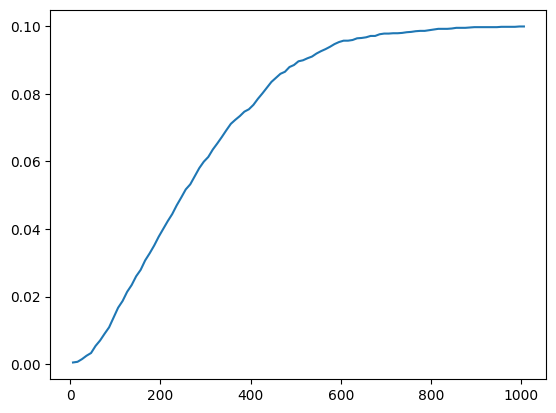

In [5]:
# First method :
# We perform a parametric estimation by Weibull distribution.
n_sample=1000
equipement_life = np.sort(data.loc[data['censored'] == False, 'event (fail or censored)'].to_list()[0:n_sample]).astype(float)
t = np.arange(1, 1020, 10)
f, v = np.histogram(equipement_life, t)

F = np.cumsum(f)
F = F / 10000
plt.plot((v[0:-1]+v[1:])/2, F)
logt = np.log((t[0:-1]+t[1:])/2)
loglogF = np.log(-np.log(1-F))

lr = LinearRegression()
logt = logt[~np.isinf(loglogF)]
loglogF = loglogF[~np.isinf(loglogF)]
lr.fit(logt.reshape(-1, 1), loglogF.reshape(-1, 1))

k_hat = lr.coef_[0][0]
lambda_hat = np.exp(lr.intercept_/(-k_hat))[0]

print('estimation k:', k_hat, 'estimation lambda:', lambda_hat)

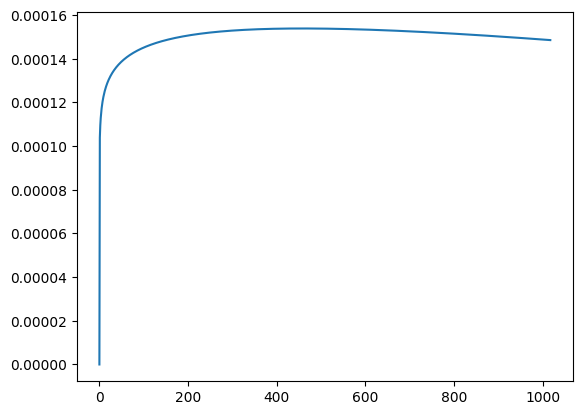

In [6]:
d = np.arange(0, np.max(equipement_life))
survival = (k_hat/lambda_hat) * np.power((d/lambda_hat),(k_hat-1))*np.exp(-np.power((d/lambda_hat), k_hat))
plt.plot(d, survival)

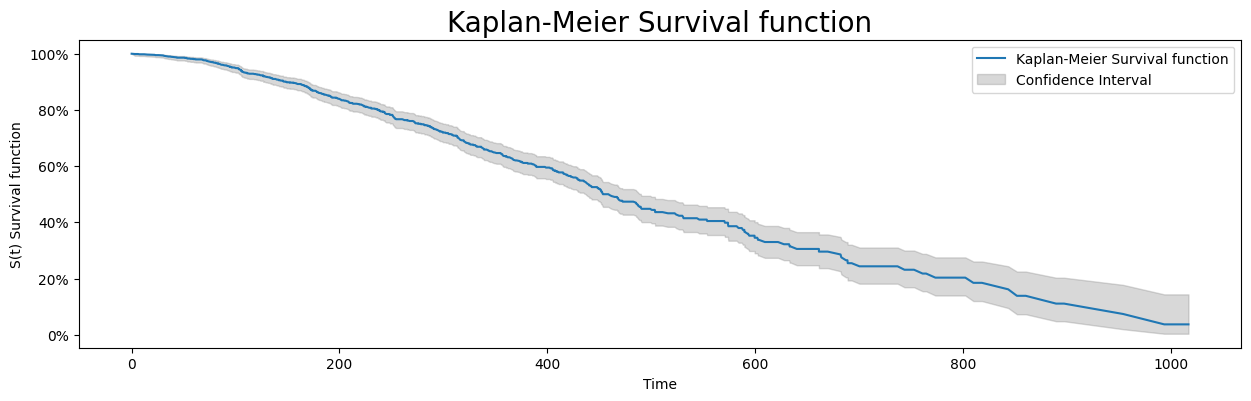

In [7]:
n_sample=1000

#Kaplan Meier
durations=data.loc[data['censored'] == False, 'event (fail or censored)'].to_list()[0:n_sample]
event_observed=data.loc[data['censored'] == False, 'usage'].to_list()[0:n_sample]
durations = np.array(durations).astype(float)
event_observed = np.array(event_observed)

# Kaplan Meier estimation
kmf = KaplanMeierFitter()

# Fitting
kmf.fit(durations, event_observed)

# Displaying the survival function and confidence intervals
fig, ax = plt.subplots(figsize=(15,4))
kmf.survival_function_.plot(ax=plt.gca())
ax.set_title("Kaplan-Meier Survival function", fontsize=20)

confidence_interval = kmf.confidence_interval_survival_function_
time_steps = confidence_interval.index
low, high = np.transpose(confidence_interval.values)
ax.fill_between(time_steps, low, high, color="gray", alpha=0.3)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylabel("S(t) Survival function")
ax.set_xlabel("Time")
ax.legend(["Kaplan-Meier Survival function", "Confidence Interval"])
plt.show()

The Kaplan-Meier estimation, which is non parametric, shows a better result than the Weibull distribution. It is a maximum likelihood estimation with regulatory hypothesis, allowing the construction of a variance estimator and a confidence interval, which is tight here.

### Maintenance strategy


We suppose to have a breakdown of the equipment costing 1000€, to pay the reparation 100€ and to buy a predictive maintenance sensor with a precision p=0.8. Which maintenance strategy will we adopt for 3 years ?

Let's study 3 maintenance strategies : a corrective maintenance, a preventive maintenance and a predictive maintenance.

In [8]:
# 1) Corrective maintainance
limit_time = 365*3
equipement_life = np.sort(data.loc[data['censored'] == False, 'event (fail or censored)'].to_list()[0:n_sample]).astype(float)
cost_samples = np.zeros(1000)
for simulation in range(1000):
    cost = 0
    limite = limit_time
    tirage = random.choice(equipement_life)
    while tirage < limite:
        cost += 1000
        limite -= tirage
        tirage = random.choice(equipement_life)
    cost_samples[simulation] = cost

print(np.mean(cost_samples))

3522.0


In [9]:
# 2) Preventive maintenance
period_to_be_tested = np.arange(1, 365*3-1, 50)
nb_sample = 1000
period_cost = np.zeros(len(period_to_be_tested))
for idp, period in enumerate(period_to_be_tested):
    cost_samples = np.zeros(nb_sample)
    for simulation in range(nb_sample):
        cost = 0
        age = 0
        # Each maintenance is planned
        for planed_maintenance in range(0, 365*3-1, period):
            # sample life of equipement after planned maintenance
            tirage = random.choice(equipement_life)
            limite = period
            # If equipement lives not long enough, there is corrective maintenance (only if age is young enough)
            if tirage < limite :
                age += tirage
            else: # else, we move to next planned maintenance
                age += period
            
            while (tirage < limite) and (age < 365*3):
                cost += 1000 
                limite -= tirage # the limit is reduced because multiple failure can occur
                tirage = random.choice(equipement_life)
                age += tirage
            cost += 100
        cost_samples[simulation] = cost
    period_cost[idp] = np.mean(cost_samples)
print(period_cost)
print("Best period:", period_to_be_tested[np.argmin(period_cost)])
print("Best cost:", period_cost[np.argmin(period_cost)])

[109400.   2807.   2332.   2256.   2320.   2320.   2401.   2532.   2564.
   2665.   2832.   2796.   2770.   2832.   2874.   2874.   2993.   3087.
   3168.   3287.   3462.   3704.]
Best period: 151
Best cost: 2256.0


In [10]:
# 3) Predictive maintenance
nb_sample = 1000
cost_samples = np.zeros(nb_sample)
for simulation in range(nb_sample):
    cost = 0
    limite = 365*3
    tirage = random.choice(equipement_life)
    age = tirage
    while (tirage < limite) and age < 365*3:
        if np.random.rand() > 0.8:
            cost += 1000
        else:
            cost += 100
        limite -= tirage
        tirage = random.choice(equipement_life)
        age += tirage
    cost_samples[simulation] = cost
print(np.mean(cost_samples)+1)

983.2


The minimum cost is realised with predictive maintenance

## RUL (Remaining Useful Life)

A cycle is a typical sequence observed by an equipment. It can corresponds to cycles estimated from physical simulations, but new cycle notions can be introduced by considering information such as the frequency of utilisation of those equipments.


The remaining useful life is the time estimation of the functionment remaining as a component of a system before it is mandatory to replace it. This estimation is made from breakdown predictions, using the work experience and diverse metrics.

### Estimating RUL by particules filtering.

This is based on : AN, Dawn, CHOI, Joo-Ho, et KIM, Nam Ho. Prognostics 101: A tutorial for particle filter-based prognostics algorithm using Matlab. Reliability Engineering & System Safety, 2013, vol. 115, p. 161-169.

It corresponds to modelise the deterioration of a battery by :
x(t+1) = x * exp(-b * dt)
x and b are unknown. Furthermore, we include gaussian noise of measurement, denoted s.
The system is breaking down if x < 0.3.

In [3]:
# Simulation step fixed at 5
dt = 5
# The measured data are :
measuData = np.array([1.000, 0.9051, 0.8012, 0.8728, 0.6554, 0.6114, 0.6830, 0.587, 0.482, 0.490]) # 
thres = 0.3
paramName = ['x', 'b', 's']
# Degradation model is defined by :
# x(t+1) = x * exp(-b * dt)

In [ ]:
# We initialize the parameters with a uniform distribution, with following values :
initDisPar = np.array([[0.9, 1.1], [0.00, 0.05], [0.01, 0.1]])
n = 5000 # Number of particles in the filter

p = len(paramName)
param = np.zeros((p, n))
paramRes = {}
for j in range(p):
    param[j, :] = np.random.rand(n)*(initDisPar[j, 1]- initDisPar[j, 0]) + initDisPar[j, 0]
    tmp = param[j, :]
    paramRes[paramName[j]] = [tmp.copy()]

k1 = len(measuData)-1
k = 0
if (measuData[-1] - measuData[0]) < 0:
    cofec = -1
else:
    cofec = 1

while ((np.max(paramRes[paramName[0]][k])) * cofec) < (thres * cofec):
    k += 1
    paramPredi = np.array(param)
    x = paramPredi[0, :]
    b = paramPredi[1, :]
    s = paramPredi[2, :]
    
    ### Prediction model

    if k <= k1:
        like1 = ss.norm.pdf(measuData[k], paramPredi[0, :], paramPredi[2, :])
        cdf = np.cumsum(like1) / np.max(np.sum(like1))
        for i in range(n):
            u = np.random.rand()
            loca = np.argwhere(cdf >= u)
            param[:, i] = paramPredi[:, loca[0][0]]
    else:
        param = paramPredi.copy()
    
    for j in range(p):
        tmp = param[j, :]
        paramRes[paramName[j]].append(tmp.copy())
    
    if k > k1:
        paramRes[paramName[0]][k] = np.random.normal(param[0, :], param[-1, :])

print('last min:', np.min(paramRes[paramName[0]][k]))
print('last max:', np.max(paramRes[paramName[0]][k]))
signiLevel = 5
time = np.arange(0, dt * np.max([(k+1), k1 + 1]), dt)
perceValue = [50, signiLevel, 100 - signiLevel]
RUL = np.zeros(n)
for i in range(n):
    loca = np.argwhere((np.array(paramRes[paramName[0]])[:, i] * cofec) >= (cofec * thres))
    RUL[i] = time[loca[0][0]] - time[k1]

In [5]:
filename = "Dataset_3.2.h5"

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W = np.array(hdf.get('W'))             # W
        X_s = np.array(hdf.get('X_s'))         # X_s
        X_v = np.array(hdf.get('X_v'))         # X_v
        T = np.array(hdf.get('T'))             # T
        Y = np.array(hdf.get('Y'))             # RUL  
        A = np.array(hdf.get('A'))             # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))

        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))

Number of cycles for which the motor is sent to maintenance

                unit          cycle
count  500000.000000  500000.000000
mean        1.828052      24.700692
std         0.767791      14.754344
min         1.000000       1.000000
25%         1.000000      12.000000
50%         2.000000      23.000000
75%         2.000000      37.000000
max         3.000000      53.000000
Engine units IDs in dataframe:  [1. 2. 3.]
Unit: 1.0 - Number of flight cyles (t_{EOF}):  53
Unit: 2.0 - Number of flight cyles (t_{EOF}):  52
Unit: 3.0 - Number of flight cyles (t_{EOF}):  32


(0.0, 120.0)

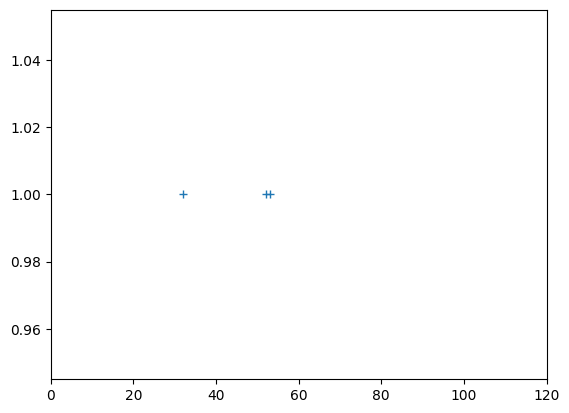

In [6]:
df_A = pd.DataFrame(data=A, columns=A_var)
print(df_A.describe())
print('Engine units IDs in dataframe: ', np.unique(df_A['unit']))
# Votre code
df_failures = pd.DataFrame()

fail = []
for i in np.unique(df_A['unit']):
    print('Unit: ' + str(i) + ' - Number of flight cyles (t_{EOF}): ', len(np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])))
    fail.append(len(np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])))

df_failures['unit'] = np.unique(df_A['unit'])
df_failures['fail'] = fail

plt.plot(df_failures['fail'], np.ones(df_failures.shape[0]), '+')
plt.xlim(0, 120)

We observe few breakdowns through time : only 3, with 2 breakdowns happening one after the other, in a little time period (we can assume the reparation was not made properly at the first time).

Visualisation of the degradation of HPT in function of the degradation LPT for each motor. Qu'en pensez-vous ?

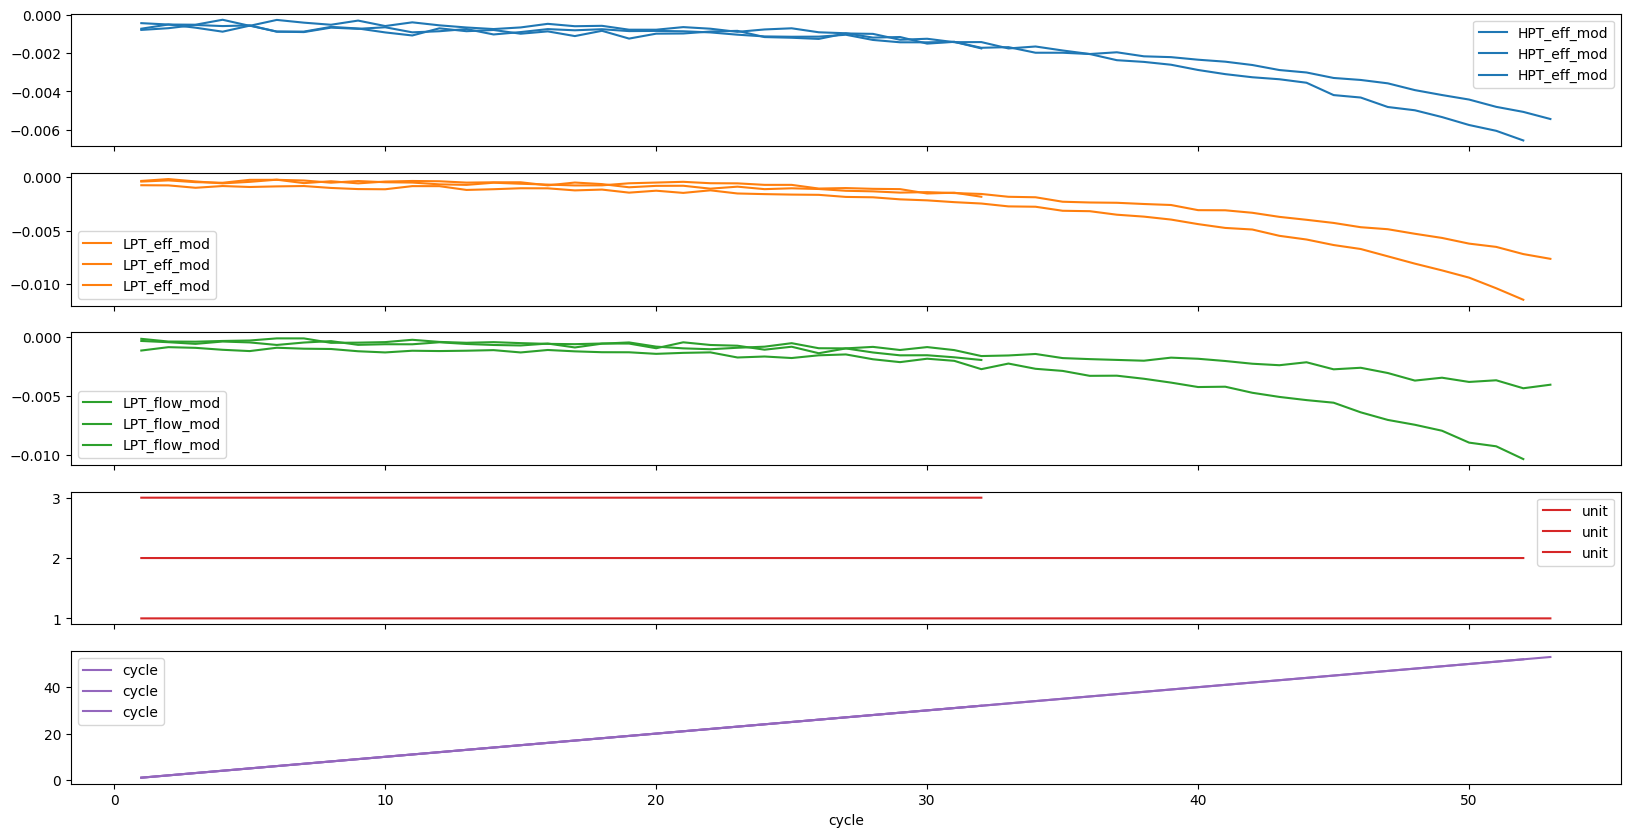

In [7]:
df_T = pd.DataFrame(data=T, columns=T_var) 
df_T['unit'] = df_A['unit'].values
df_T['cycle'] = df_A['cycle'].values
df_T.describe()

first = True
for u in df_A['unit'].unique():
    if first:
        df_tmp = df_T.loc[df_A['unit']==u]
        df_tmp.index = df_T['cycle'].loc[df_A['unit']==u]
        ax = df_tmp.plot(subplots=True, figsize=(20, 10))
        first = False
    else:
        df_tmp = df_T.loc[df_A['unit']==u]
        df_tmp.index = df_T['cycle'].loc[df_A['unit']==u]
        df_tmp.plot(subplots=True, figsize=(20, 10), ax= ax)

In [8]:
# Sensors dataframe
df_X_s = pd.DataFrame(data=X_s, columns=X_s_var) 
df_X_v = pd.DataFrame(data=X_v, columns=X_v_var) 

We use StratifiedShuffleSplit for train / validation / test split of the dataframe

In [9]:
ssf = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

## Data cleaning and selection

The three types of possible missing data are :

* Completely Random Missing Data (MCAR)
* Random Missing Data (MAR)
* Deterministic Missing Data (MNAR)

The cons of replacing data by the mean of samples is to approximate by introducing a bias in the dataframe. Depending on the issue, it can introduce too much bias and therefore lead to approximation error.

For MNAR, it is better not to use this approximation as the missing data are relevant : they can provide information, such as a measure is outside the measuring range of a sensor, for example, which is an information we do not want to loose for learning. We prefer to introduce a categorical value instead of replacing the missing value by the mean of data.

Sometimes, deleting the missing data is an issue as it deletes a high amount of samples in the dataset. If deleting the missing data corresponds of removing 80% of the dataset, then we can't perform a robust learning with the remaining dataset. A bad prediction can be caused by a high imbalance ratio in the data, especially for classification.

In [10]:
filename = "Dataset_4.1.h5"

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W = np.array(hdf.get('W'))             # W
        X_s = np.array(hdf.get('X_s'))         # X_s
        X_v = np.array(hdf.get('X_v'))         # X_v
        T = np.array(hdf.get('T'))             # T
        Y = np.array(hdf.get('Y'))             # RUL  
        A = np.array(hdf.get('A'))             # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))

        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
    
df_A = pd.DataFrame(data=A, columns=A_var)
print(df_A.describe())
print('Engine units IDs in the dataframe: ', np.unique(df_A['unit']))
df_T = pd.DataFrame(data=T, columns=T_var) 
df_T['unit'] = df_A['unit'].values
df_T['cycle'] = df_A['cycle'].values
# Dataframe of sensors
df_X_s = pd.DataFrame(data=X_s, columns=X_s_var) 
df_X_v = pd.DataFrame(data=X_v, columns=X_v_var)

                unit          cycle
count  500000.000000  500000.000000
mean        2.608702      32.495176
std         1.076259      19.438390
min         1.000000       1.000000
25%         2.000000      16.000000
50%         2.000000      32.000000
75%         4.000000      48.000000
max         4.000000      75.000000
Engine units IDs in the dataframe:  [1. 2. 3. 4.]


Let visualise those data

In [11]:
# First, we show values and types for each variable
for i in df_A.keys():
    print(df_A[i].iloc[0:3])

for j in df_T.keys():
    print(df_T[j].iloc[0:3])

for k in df_X_s.keys():
    print(df_X_s[k].iloc[0:3])

for l in df_X_v.keys():
    print(df_X_v[l].iloc[0:3])

0    1.0
1    1.0
2    1.0
Name: unit, dtype: float64
0    1.0
1    1.0
2    1.0
Name: cycle, dtype: float64
0   -0.000612
1   -0.000612
2   -0.000612
Name: HPT_eff_mod, dtype: float64
0   -0.001029
1   -0.001029
2   -0.001029
Name: LPT_eff_mod, dtype: float64
0   -0.000784
1   -0.000784
2   -0.000784
Name: LPT_flow_mod, dtype: float64
0    1.0
1    1.0
2    1.0
Name: unit, dtype: float64
0    1.0
1    1.0
2    1.0
Name: cycle, dtype: float64
0    1953.949543
1    1953.952454
2    1953.877076
Name: T48, dtype: float64
0    448.927946
1    448.994394
2    448.951777
Name: Ps30, dtype: float64
0    2271.183351
1    2271.452480
2    2271.640295
Name: Nf, dtype: float64
0    8867.826621
1    8868.204160
2    8868.351007
Name: Nc, dtype: float64
0    5.534608
1    5.534968
2    5.533891
Name: Wf, dtype: float64
0    2990.900398
1    2990.880324
2    2990.752887
Name: T40, dtype: float64
0    34.609880
1    34.615291
2    34.612916
Name: W31, dtype: float64


In [12]:
# We visualise the mean of data in the dataframe
print("df_A : ")
print(pd.DataFrame(df_A.isna().mean()),"\n")
print("df_T : ")
print(pd.DataFrame(df_T.isna().mean()),"\n")
print("df_X_s : ")
print(pd.DataFrame(df_X_s.isna().mean()),"\n")
print("df_X_v : ")
print(pd.DataFrame(df_X_v.isna().mean()),"\n")

df_A : 
         0
unit   0.0
cycle  0.0 

df_T : 
                0
HPT_eff_mod   0.0
LPT_eff_mod   0.0
LPT_flow_mod  0.0
unit          0.0
cycle         0.0 

df_X_s : 
             0
T48   0.006994
Ps30  0.006880
Nf    0.006912
Nc    0.007124
Wf    0.007074 

df_X_v : 
       0
T40  0.0
W31  0.0 



This dataset is composed of numerical data and only the dataframe df_X_s has missing values, but those corresponds to a little proportion of the dataset, around 10^-3.

Therefore, there is no need to perform specific detection of anomalies in the data. Let visualise it anyway.

<Axes: >

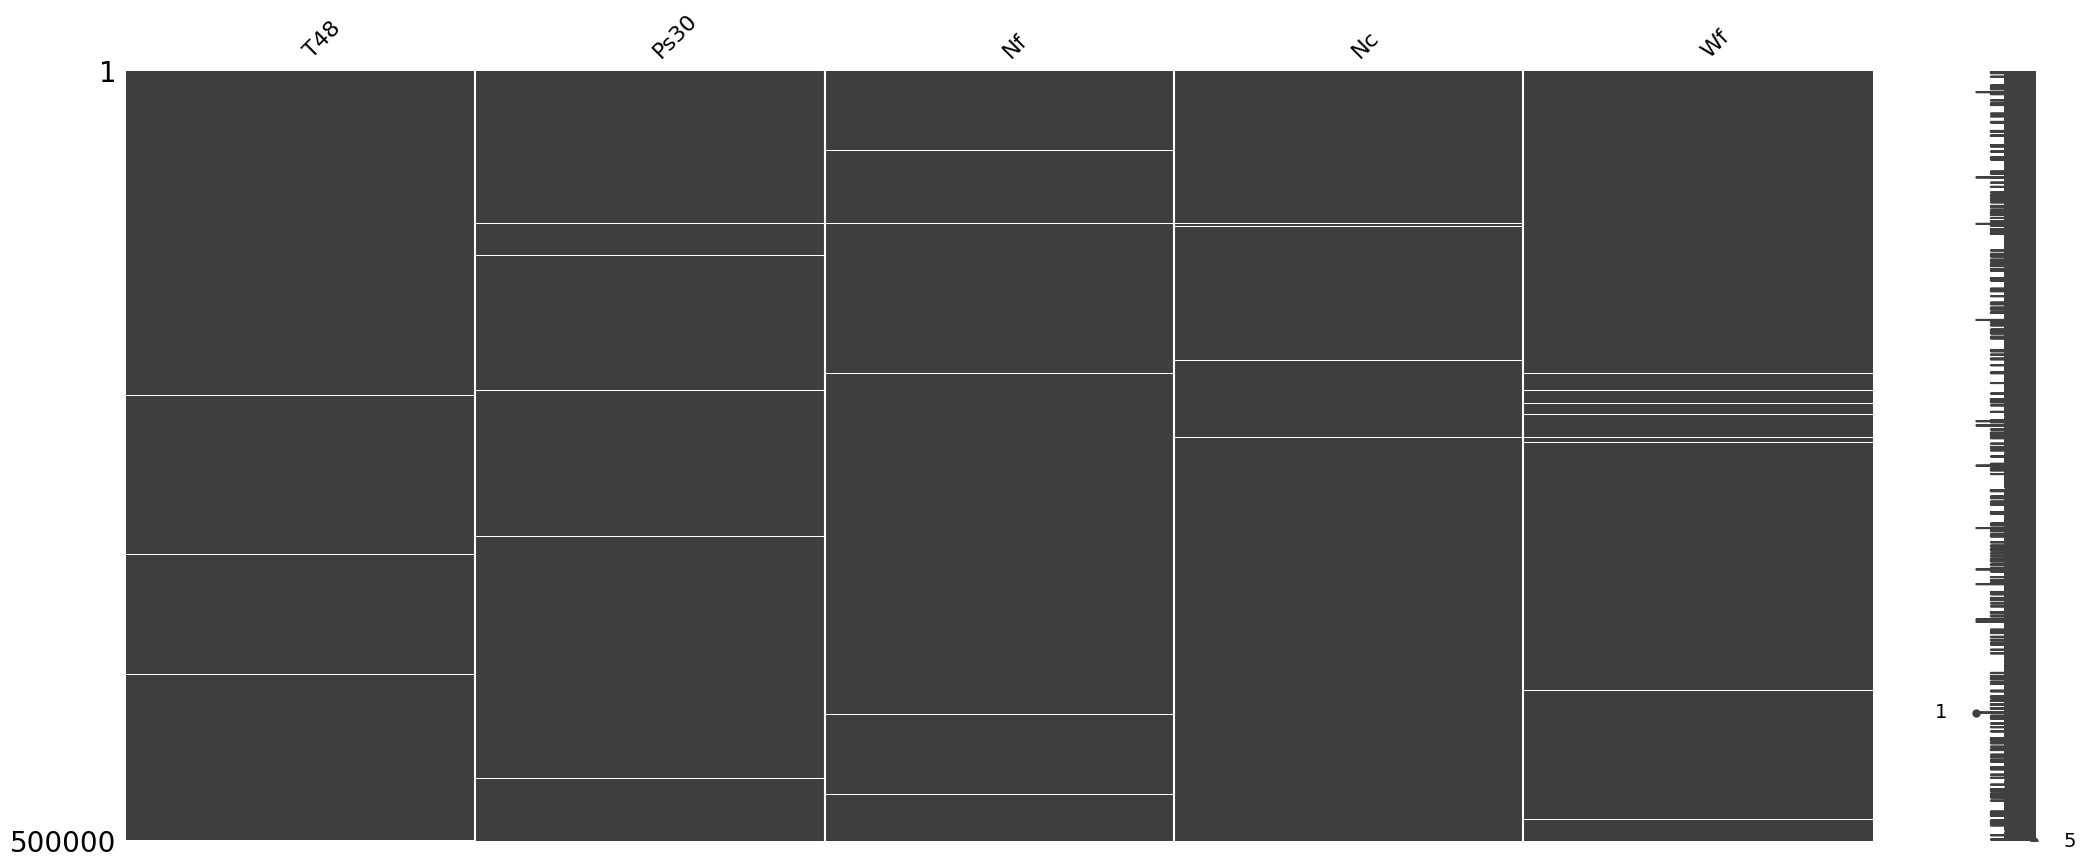

In [13]:
# We use missingno value
missingno.matrix(df_X_s)

In [14]:
df_X_s_dropna= df_X_s.dropna()
print(len(df_X_s_dropna)/len(df_X_s))
# Removing missing data only remove 3% of the dataset

0.971274


Furthermore, it seems the missing values are not significant, as they corresponds to a little proportion of the dataset and there is no specific schema in the visualisation, which would be caused by a precise phenomenom at the origin of the missing values. Here, we can suppose missing values are purely random.

Let's proceed now at the detection of anomalies. We choose a Isolation Forest model which is convenient for the dataset we have, as it does not present specific irregularities.

In [15]:
myRIF = IsolationForest(n_estimators=500, contamination=0.1)
df_X_s_dropna.loc[:, '_isoutlier'] = myRIF.fit_predict(df_X_s_dropna)
df_X_v.loc[:, '_isoutlier'] = myRIF.fit_predict(df_X_v)

print(f"anomaly percent in senser X_s: {100*(df_X_s_dropna.loc[:, '_isoutlier']==-1).mean()} %")
print(f"anomaly percent in senser X_v: {100*(df_X_v.loc[:, '_isoutlier']==-1).mean()} %")

anomaly percent in senser X_s: 9.99985585941763 %
anomaly percent in senser X_v: 10.0 %


We obtain 10% of outliers in the dataset. Let's visualise them :

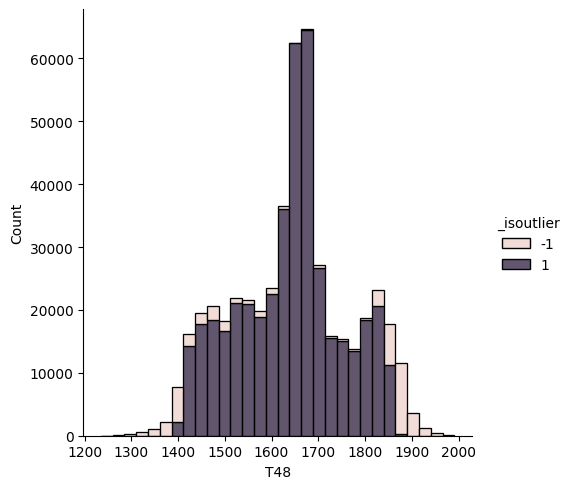

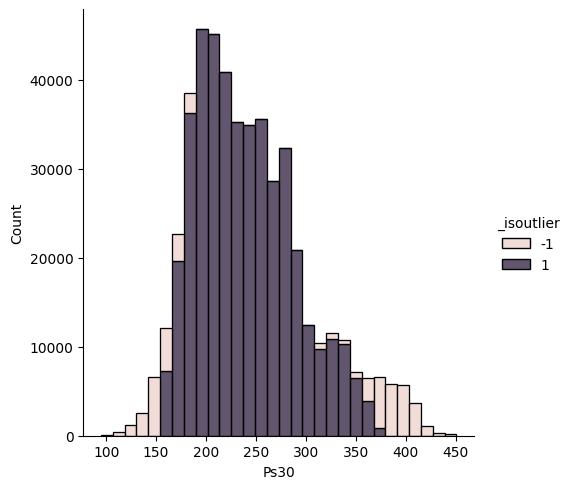

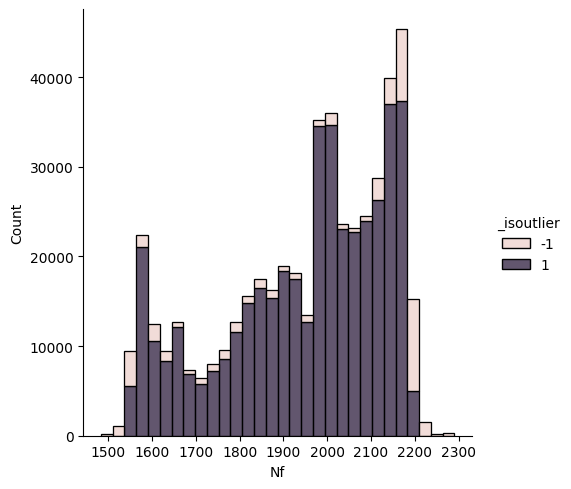

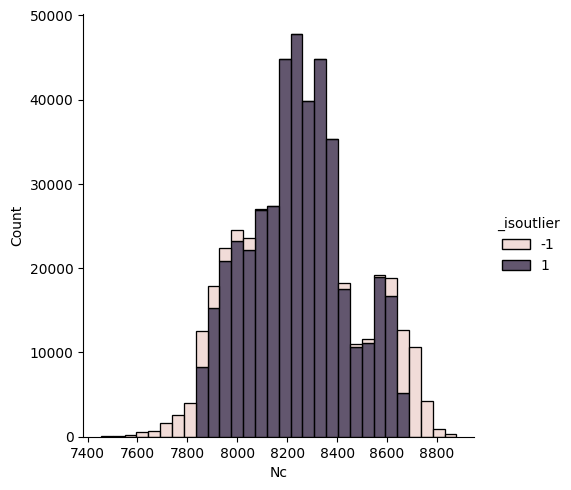

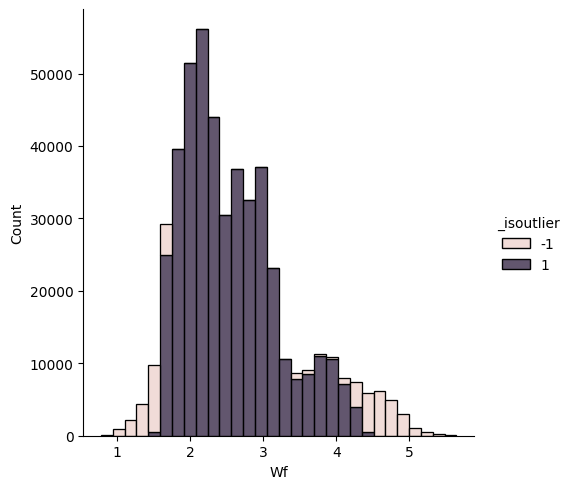

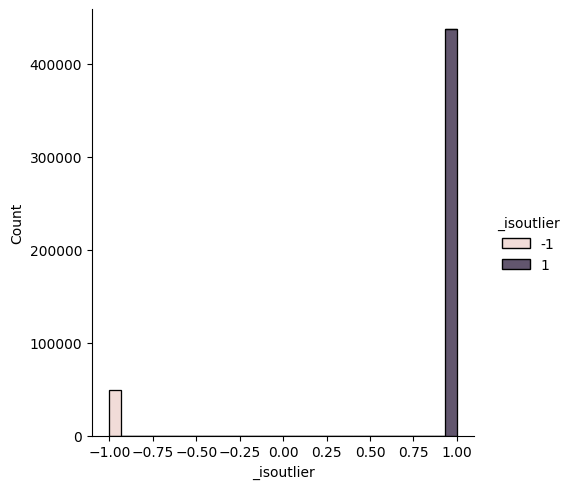

In [16]:
for k in df_X_s_dropna.keys():
    sns.displot(data=df_X_s_dropna, x=k, hue='_isoutlier', kind='hist', bins=30, multiple="stack")

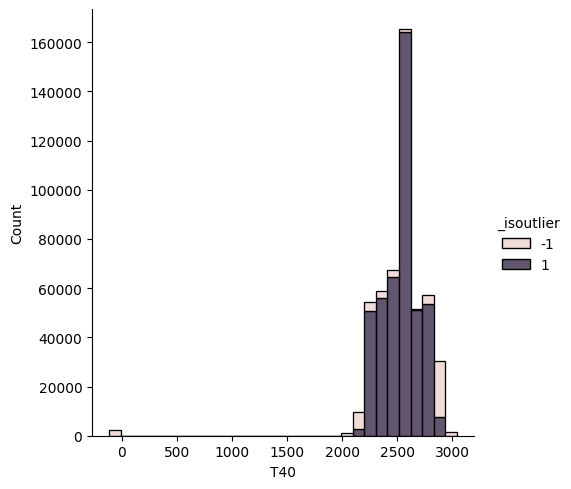

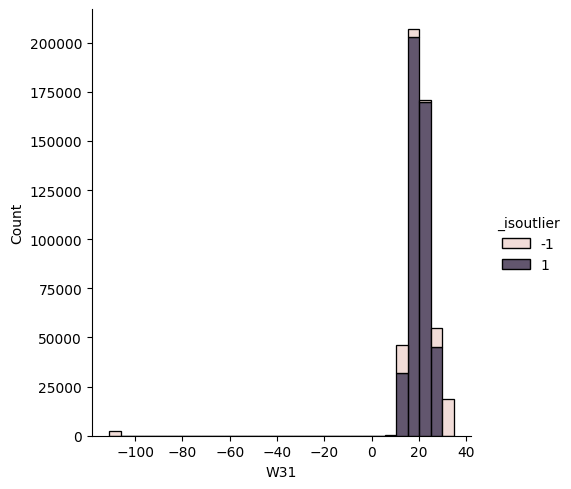

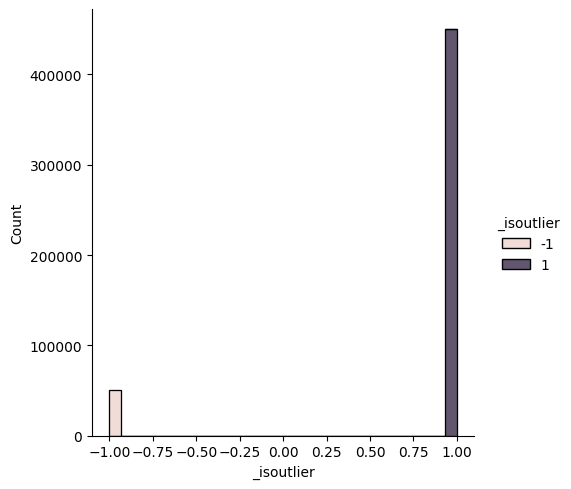

In [17]:
for k in df_X_v.keys():
    sns.displot(data=df_X_v, x=k, hue='_isoutlier', kind='hist', bins=30, multiple="stack")

We can visualise that those outliers corresponds to extreme values of the dataset, we can remove them. 

## Diagnostic tools for maintenance




The acronym FMEA signifies Failure Mode & Effects Analysis. It corresponds to quantitative analysis which deepen the notion of criticity of failures and bring a better understanding of the propagation process of the failures thanks to fault trees.

We will analyse a robot distributing pizzas.
It can have 3 distincts types of breakdowns:
- pizza food
- robot dead
- piloting issue
We can query 3 questions :
- Is there pizzas (istherepizza) ?
- Robot is broken (isrobotdead) ?
- Does the screen show an error code (question_isscreenok) ?
We can perform 3 actions :
- Repairing the robot
- Fill in food
- Reboot

We use the bnlearn package : https://erdogant.github.io/bnlearn/pages/html/index.html 

In [18]:
edges = [('pizza_food', 'robotic_arm'),
         ('robotic_arm', 'pilote'),
         ('pizza_food', 'pilote'),
         ('robotic_arm', 'question_isrobotdead'),
         ('pizza_food', 'question_istherepizza'),
         ('robotic_arm', 'question_isscreenok'),
         ('pilote', 'question_isscreenok'),
         ('pizza_food', 'question_isscreenok'),
         ('pilote', 'action_repair_robotic_arm'),
         ('pilote', 'action_addpizzafood'),
         ('pilote', 'action_reboot'),
         ('pizza_food', 'action_repair_robotic_arm'),
         ('pizza_food', 'action_addpizzafood'),
         ('pizza_food', 'action_reboot'),
         ('robotic_arm', 'action_repair_robotic_arm'),
         ('robotic_arm', 'action_addpizzafood'),
         ('robotic_arm', 'action_reboot'),
         ]
DAG = bnlearn.make_DAG(edges)

[bnlearn] >bayes DAG created.


Chargez les données 'data_pizza_robot.csv'

In [19]:
dfa = pd.read_csv('data_pizza_robot.csv', sep=';')
dfa.head()

,Unnamed: 0,pizza_food,question_istherepizza,robotic_arm,question_isrobotdead,pilote,question_isscreenok,action_repair_robotic_arm,action_addpizzafood,action_reboot
0,0,1,1,0,0,1,1,1,0,1
1,1,1,1,1,1,0,0,1,1,0
2,2,1,1,0,0,1,1,1,0,1
3,3,1,1,0,0,1,1,1,0,1
4,4,0,0,1,1,1,0,0,1,1


Learning the parameters from bayesian network

In [20]:
DAG = bnlearn.parameter_learning.fit(DAG, dfa, methodtype='bayes')

[bnlearn] >Removing columns from dataframe to make consistent with DAG [['Unnamed: 0']]
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of pizza_food:
+---------------+---------+
| pizza_food(0) | 0.28583 |
+---------------+---------+
| pizza_food(1) | 0.71417 |
+---------------+---------+
[bnlearn] >CPD of robotic_arm:
+----------------+---------------------+---------------------+
| pizza_food     | pizza_food(0)       | pizza_food(1)       |
+----------------+---------------------+---------------------+
| robotic_arm(0) | 0.10158472165786266 | 0.685639941453895   |
+----------------+---------------------+---------------------+
| robotic_arm(1) | 0.8984152783421373  | 0.31436005854610505 |
+----------------+---------------------+---------------------+
[bnlearn] >CPD of pilote:
+-------------+----------------+-----+---------------------+
| pizza_food  | pizza_food(0)  | ... | pizza_food(1)       |
+-------------+----------------+-----+------------------

The probabilities for each breakdown are :

p(pizza_food=0) = 0.3

p(robotic_arm=0) = p(robotic_arm=0|pizza_food=0)p(pizza_food=0) + p(robotic_arm=0|pizza_food=1)p(pizza_food=1) = 0.1\*0.3 + 0.7\*0.7 = 0.38

p(pilote=0) = 0.5\*p(robotic_arm=0|pizza_food=0)+ 
0.056535504296698326\*p(robotic_arm=1|pizza_food=0)+
0.204696394686907\*p(robotic_arm=0|pizza_food=1)+
0.9353336782203828\*p(robotic_arm=1|pizza_food=1)
= 0.54

We can make queries such as, if we know "question_isscreenok" is 1, what is the probability of missing food ?

In [21]:
result = bnlearn.inference.fit(DAG, variables=['pizza_food'], evidence={'question_isscreenok':1})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+--------------+----------+
|    |   pizza_food |        p |
+====+==============+==========+
|  0 |            0 | 0.292222 |
+----+--------------+----------+
|  1 |            1 | 0.707778 |
+----+--------------+----------+


We see p(pizza_food=0) = 0.3

Let define a routine for identifying a breakdown we do not know

We look at the maximum probability concerning actions we can undertake, by supposing everything is fine (so we suppose to have food remaining and no error code on the screen)

In [22]:
qreboot = bnlearn.inference.fit(DAG, variables=['action_reboot'], evidence={'question_istherepizza':1, 'question_isscreenok':1})
qrepair = bnlearn.inference.fit(DAG, variables=['action_repair_robotic_arm'], evidence={'question_istherepizza':1, 'question_isscreenok':1})
qaddfood = bnlearn.inference.fit(DAG, variables=['action_addpizzafood'], evidence={'question_istherepizza':1, 'question_isscreenok':1})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+-----------------+----------+
|    |   action_reboot |        p |
+====+=================+==========+
|  0 |               0 | 0.225936 |
+----+-----------------+----------+
|  1 |               1 | 0.774064 |
+----+-----------------+----------+
[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+-----------------------------+----------+
|    |   action_repair_robotic_arm |        p |
+====+=============================+==========+
|  0 |                           0 | 0.169936 |
+----+-----------------------------+----------+
|  1 |                           1 | 0.830064 |
+----+-----------------------------+----------+
[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+-----------------------+---------+
|    |   action_addpizzafood |       p |
+====+=======================+=========+
|  0 |                     0 | 0.66167 |
+----+--------------------

We choose to repair the robotic arm and eventually to reboot (probabilities of 0.83 and 0.77). The probability of missing food being 0.34, it is not our priority here.

We add data about cost maintenance to our problem. We have the following properties :
- action_addpizzafood cost 50€ in 1h
- action_repair_robotic_arm cost 1000€ in 12h
- action reboot cost 0€ in 5h

Now, let's consider the action to undertake when there is food and the screen shows an error ?

We look at the maximum probability of action in function of what we know

In [23]:
qreboot = bnlearn.inference.fit(DAG, variables=['action_reboot'], evidence={'question_istherepizza':1, 'question_isscreenok':0})
qrepair = bnlearn.inference.fit(DAG, variables=['action_repair_robotic_arm'], evidence={'question_istherepizza':1, 'question_isscreenok':0})
qaddfood = bnlearn.inference.fit(DAG, variables=['action_addpizzafood'], evidence={'question_istherepizza':1, 'question_isscreenok':0})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+-----------------+----------+
|    |   action_reboot |        p |
+====+=================+==========+
|  0 |               0 | 0.453556 |
+----+-----------------+----------+
|  1 |               1 | 0.546444 |
+----+-----------------+----------+
[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+-----------------------------+----------+
|    |   action_repair_robotic_arm |        p |
+====+=============================+==========+
|  0 |                           0 | 0.172848 |
+----+-----------------------------+----------+
|  1 |                           1 | 0.827152 |
+----+-----------------------------+----------+
[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+-----------------------+----------+
|    |   action_addpizzafood |        p |
+====+=======================+==========+
|  0 |                     0 | 0.279736 |
+----+----------------

Now, the actions of highest probabilities is to add pizza (probability of 0.72) and to repair the arm robot (probability of 0.82).
The reboot has a probability of 0.55, which is not negligeable.

Because of the cost constraints and time of use, it is better to focus on actions of adding pizza and reboot, especially as those can be done simulatenously